Reading CANSIM NDM vectors from temporary cache

Reading CANSIM NDM vectors from temporary cache

Warning message in optim(par = inits, fn = likfn, model = model, ...):
"one-dimensional optimization by Nelder-Mead is unreliable:
use "Brent" or optimize() directly"


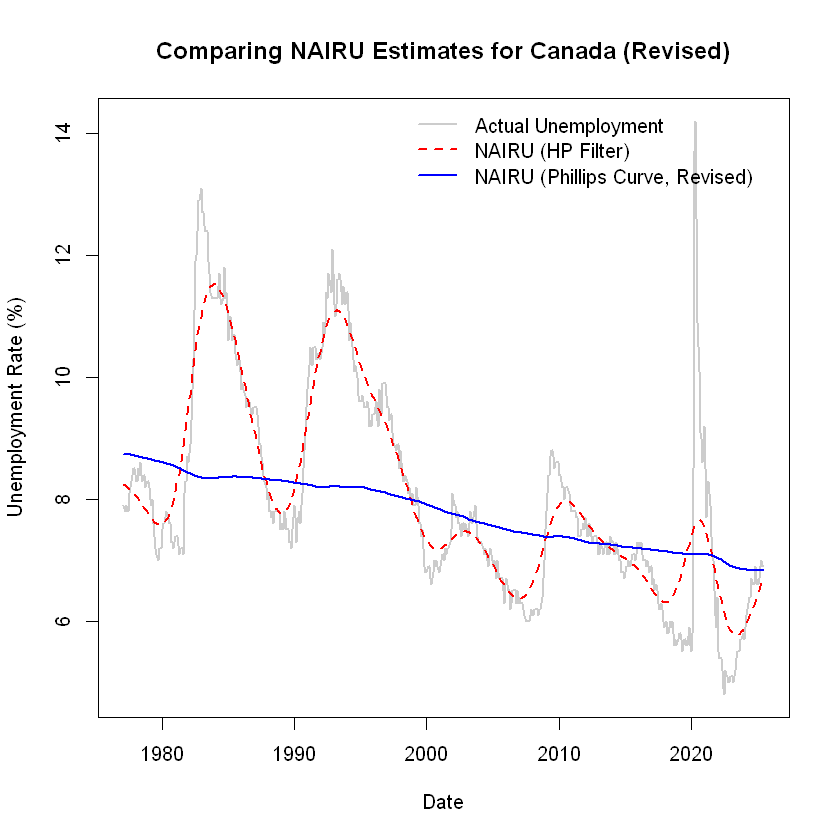

In [6]:
# 1. LOAD LIBRARIES
# ------------------
# install.packages("KFAS") # You may need to install this first
library(cansim)
library(dplyr)
library(lubridate)
library(KFAS)

# 2. GET & PREPARE DATA
# ---------------------
# Unemployment Rate (your original vector)
unemp_df <- get_cansim_vector_for_latest_periods('v2062815', periods = 3000) |>
  select(date = Date, unemp_rate = VALUE)

# Consumer Price Index (for inflation)
cpi_df <- get_cansim_vector_for_latest_periods('v41690973', periods = 3000) |>
  select(date = Date, cpi = VALUE)

# Combine, create monthly dates, and calculate inflation
full_data <- left_join(unemp_df, cpi_df, by = "date") |>
  mutate(month = floor_date(date, "month")) |>
  # Group by month to handle potential daily data and take the last observation
  group_by(month) |>
  summarise(
    unemp_rate = last(unemp_rate),
    cpi = last(cpi)
  ) |>
  ungroup() |>
  # Calculate Year-over-Year Inflation Rate (%)
  mutate(
    inflation_rate = (cpi / lag(cpi, 12) - 1) * 100
  ) |>
  # Calculate the change in inflation (the dependent variable, delta_pi)
  mutate(
    delta_inflation = inflation_rate - lag(inflation_rate, 1)
  ) |>
  tidyr::drop_na() # Remove NAs created by lags

# 3. METHOD 1: HP FILTER (Your Original Method)
# ---------------------------------------------
hp_results <- mFilter::hpfilter(full_data$unemp_rate, type = "lambda", freq = 14400)
full_data$nairu_hp <- as.numeric(hp_results$trend)

SIGNAL_VARIANCE <- 0.00001

model_kfas_fixed_q <- SSModel(
  delta_inflation ~ unemp_rate + SSMtrend(1, Q = list(SIGNAL_VARIANCE)),
  data = full_data, H = list(NA)
)

# Now we only need to estimate one parameter (H), the observation noise.
fit_kfas_fixed_q <- fitSSM(model_kfas_fixed_q, inits = 0)

# Run the Kalman smoother on the new model with the fixed Q.
kfs_results_fixed_q <- KFS(fit_kfas_fixed_q$model)

# Extract the estimated states as before
beta_coef <- kfs_results_fixed_q$alphahat[1, "unemp_rate"]
time_varying_intercept <- kfs_results_fixed_q$alphahat[, "level"]

# Calculate the Kalman Filter NAIRU from the revised model
full_data$nairu_kf_revised <- time_varying_intercept / (-beta_coef)


# 5. VISUALIZE THE RESULTS
# ------------------------
plot(full_data$month, full_data$unemp_rate, type = 'l', col = 'gray80', lwd = 2,
     main = "Comparing NAIRU Estimates for Canada (Revised)",
     xlab = "Date", ylab = "Unemployment Rate (%)",
     ylim = range(c(full_data$unemp_rate, full_data$nairu_hp, full_data$nairu_kf_revised), na.rm = TRUE))

lines(full_data$month, full_data$nairu_hp, col = 'red', lwd = 2, lty = "dashed")
lines(full_data$month, full_data$nairu_kf_revised, col = 'blue', lwd = 2)

legend("topright",
       legend = c("Actual Unemployment", "NAIRU (HP Filter)", "NAIRU (Phillips Curve, Revised)"),
       col = c("gray80", "red", "blue"),
       lty = c(1, 2, 1),
       lwd = 2,
       bty = "n")